In [3]:
import torch
import torchvision
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import torch.nn as nn
import os
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shutil
from sklearn.model_selection import train_test_split
import optuna
import torch.optim as optim
import optuna.visualization as vis
from tqdm import tqdm  # Import tqdm for progress tracking

/home/kanishkaman/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for ResNet18
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class FaceDataset(Dataset):
    def __init__(self, img_dir, attr_file, transform=None, subset_size=None):
        self.img_dir = img_dir
        self.attr_data = pd.read_csv(attr_file)
        self.attr_data = self.attr_data[['image_id', 'Arched_Eyebrows']]  # Focus on the 'Arched_Eyebrows' column
        
        # Optionally use a smaller subset for efficiency
        if subset_size:
            self.attr_data = self.attr_data.sample(n=subset_size, random_state=42)
        self.transform = transform
        self.img_names = self.attr_data['image_id'].values
        self.labels = self.attr_data['Arched_Eyebrows'].values
 
    def __len__(self):
        return len(self.img_names)
 
    def __getitem__(self, idx):
        img_path = f"{self.img_dir}/{self.img_names[idx]}"
        
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"Image {img_path} not found. Skipping.")
            return None  
        
        label = (self.labels[idx] == 1).astype(float)  # Binary label (1 or 0)
 
        if self.transform:
            image = self.transform(image)
 
        return image, label


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
            ## JUST FOR CREATION OF SUBSET DATA!!!

# SET ALL THE CORRECT PATHS HERE!!!
img_dir = 'face_images/img_align_celeba'  
attr_file = 'face_image_attr.csv'
small_img_dir = 'small_img_align_celeba'  # New directory for smaller dataset
subset_size = 150000  # Define how many images you want in the smaller dataset

# Create the directory for the smaller dataset if it doesn't exist
if not os.path.exists(small_img_dir):
    os.makedirs(small_img_dir)

attr_data = pd.read_csv(attr_file)
attr_data = attr_data[['image_id', 'Arched_Eyebrows']]  # Focus only on the necessary column

# Take a random subset of the data
subset_data = attr_data.sample(n=subset_size, random_state=42)

# Loop through the subset and copy the images to the new directory
for img_name in subset_data['image_id']:
    original_img_path = os.path.join(img_dir, img_name)
    new_img_path = os.path.join(small_img_dir, img_name)
    
    if os.path.exists(original_img_path):
        shutil.copyfile(original_img_path, new_img_path)  # Copy image to new location
    else:
        print(f"Image {img_name} not found in {img_dir}")

# Save the attribute data of the subset to a new CSV file
subset_data.to_csv('small_face_image_attr.csv', index=False)

print(f"Created a smaller dataset with {subset_size} images in {small_img_dir}")

Created a smaller dataset with 150000 images in small_img_align_celeba


In [7]:
# Create separate directories for train and validation datasets
attr_file = 'small_face_image_attr.csv'  # Attribute file for the smaller dataset
train_img_dir = 'trial/train_img_align_celeba'
val_img_dir = 'trial/val_img_align_celeba'
train_attr_file = 'train_face_image_attr.csv'
val_attr_file = 'val_face_image_attr.csv'
img_dir = 'small_img_align_celeba'

attr_data = pd.read_csv(attr_file)

# Create directories if they don't exist
if not os.path.exists(train_img_dir):
    os.makedirs(train_img_dir)

if not os.path.exists(val_img_dir):
    os.makedirs(val_img_dir)

# Split the data into train and validation sets (80% train, 20% validation)
train_data, val_data = train_test_split(attr_data, test_size=0.2, random_state=42, stratify=attr_data['Arched_Eyebrows'])

# Function to copy images to the respective directory
def copy_images(img_list, source_dir, destination_dir):
    for img_name in img_list:
        original_img_path = os.path.join(source_dir, img_name)
        new_img_path = os.path.join(destination_dir, img_name)
        
        if os.path.exists(original_img_path):
            shutil.copyfile(original_img_path, new_img_path)  # Copy image to the destination folder
        else:
            print(f"Image {img_name} not found in {source_dir}")

# Copy images to train and validation directories (from img_dir to train and val dir)
copy_images(train_data['image_id'], img_dir, train_img_dir)
copy_images(val_data['image_id'], img_dir, val_img_dir)

# Save the train and validation attribute data to CSV files
train_data.to_csv('train_face_image_attr.csv', index=False)
val_data.to_csv('val_face_image_attr.csv', index=False)

In [8]:
train_dataset = FaceDataset(img_dir=train_img_dir, attr_file=train_attr_file, transform=transform)
val_dataset = FaceDataset(img_dir=val_img_dir, attr_file=val_attr_file, transform=transform)

# DataLoader for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Using device: cuda


In [9]:
model = models.resnet18(pretrained=True)

# # If you want to Freeze prev layers
# for param in model.parameters():
#     param.requires_grad = False
# 

model.fc = nn.Linear(in_features=model.fc.in_features, out_features=1)  # Binary classification output (1 or 0)
model = model.to(device)  # Moving model to GPU
print(device)

/home/kanishkaman/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kanishkaman/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


In [10]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
num_epochs = 4  # Specify the number of epochs you want to run it for
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to GPU
        
        optimizer.zero_grad()
        outputs = model(images).squeeze(1)  # Forward pass
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        running_loss += loss.item()
    
    train_Loss = (running_loss/len(train_loader))
    train_losses.append(train_Loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to GPU
            
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Collect outputs and labels for metric calculations
            all_outputs.extend(torch.sigmoid(outputs).cpu().numpy())  # Move to CPU before converting to numpy
            all_labels.extend(labels.cpu().numpy())

    all_outputs = np.array(all_outputs)
    all_labels = np.array(all_labels)

    preds = (all_outputs >= 0.5).astype(int)

    # Calculating all the required metrics
    accuracy = accuracy_score(all_labels, preds)
    precision = precision_score(all_labels, preds)
    f1 = f1_score(all_labels, preds)
    roc_auc = roc_auc_score(all_labels, all_outputs)
    conf_matrix = confusion_matrix(all_labels, preds)

    print(f"Validation Loss: {val_loss/len(val_loader)}")
    val_Loss = (val_loss/len(val_loader))
    val_losses.append(val_Loss)
    print(f"Accuracy: {accuracy*100:.4f}%, Precision: {precision:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
    torch.save(model.state_dict(), f'resnet18final_epoch_{epoch+1}.pth')

Epoch [1/4], Loss: 0.3322801591565567
Validation Loss: 0.3305162883559824
Accuracy: 84.3688%, Precision: 0.7176, F1 Score: 0.6992, ROC AUC: 0.9090
Epoch [2/4], Loss: 0.3193398276873886
Validation Loss: 0.3472101145911292
Accuracy: 84.5187%, Precision: 0.7820, F1 Score: 0.6668, ROC AUC: 0.9092
Epoch [3/4], Loss: 0.308924098088376
Validation Loss: 0.33606421926233454
Accuracy: 84.3187%, Precision: 0.7243, F1 Score: 0.6932, ROC AUC: 0.9087
Epoch [4/4], Loss: 0.2976620552066979
Validation Loss: 0.3359029830931686
Accuracy: 84.4250%, Precision: 0.7340, F1 Score: 0.6904, ROC AUC: 0.9083


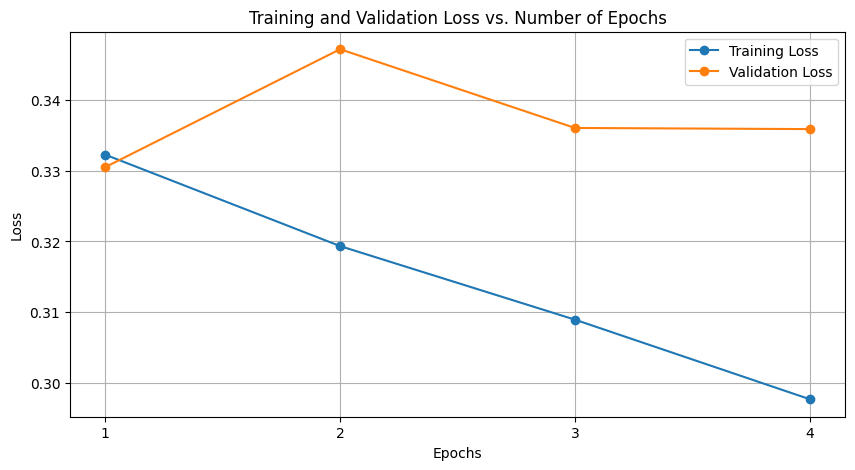

In [13]:
epoch_list = range(1, num_epochs+1)
# Plot training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epoch_list)
plt.grid(True)
plt.show()

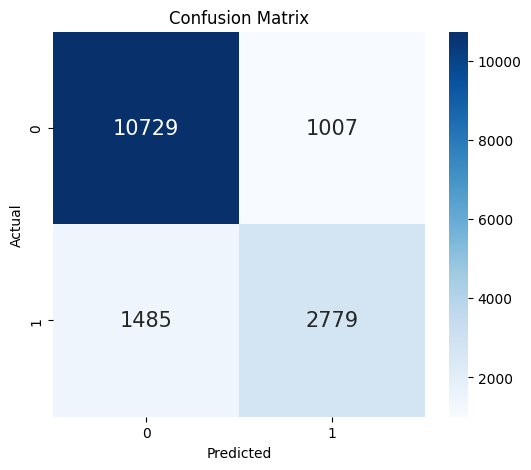

In [14]:
# Confusion Matrix
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, annot_kws={"size": 15})
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(conf_matrix)

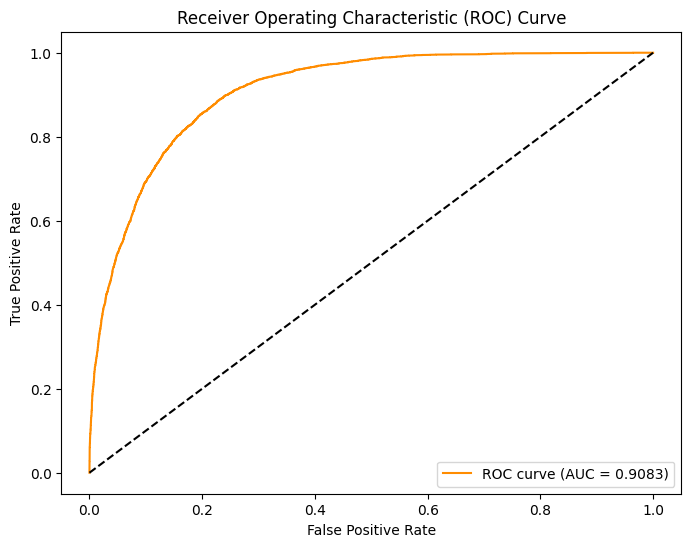

In [15]:
# ROC Curve
def plot_roc_curve(all_labels, all_outputs):
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_outputs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})", color='darkorange')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(all_labels, all_outputs)

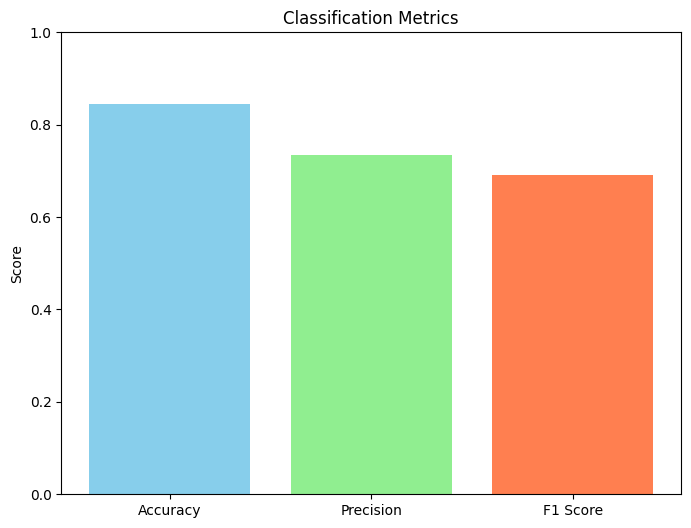

In [16]:
# Visualize Accuracy, Precision, F1 Score using a bar plot
def plot_metrics(accuracy, precision, f1):
    metrics = {'Accuracy': accuracy, 'Precision': precision, 'F1 Score': f1}
    plt.figure(figsize=(8, 6))
    plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'lightgreen', 'coral'])
    plt.title('Classification Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.show()

plot_metrics(accuracy, precision, f1)

## Question 2

In [17]:
model = models.resnet18(pretrained=False)  # Load untrained ResNet18
model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=1)
model.load_state_dict(torch.load('resnet18final_epoch_3.pth'))  # Load your trained weights, ADJUST the weights file path here accordingly.
model.eval()

/home/kanishkaman/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kanishkaman/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_5264/1726912742.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `Tr

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to preprocess the input image
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0)  # Add batch dimension
    return image.to(device)

print(device)

cuda


In [25]:
# Function to visualize activation maps
def visualize_activations(activation_maps, num_columns=8):
    num_filters = activation_maps.shape[1]
    
    num_rows = (num_filters + num_columns - 1) // num_columns
    
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 20))
    axes = axes.flatten()
    
    for i in range(num_filters):
        img = activation_maps[0, i].cpu().detach().numpy()
        axes[i].imshow(img, cmap='viridis')
        axes[i].axis('off')
    
    for i in range(num_filters, len(axes)):
        axes[i].axis('off')
    
    plt.show()

Visualizing activations from conv1...


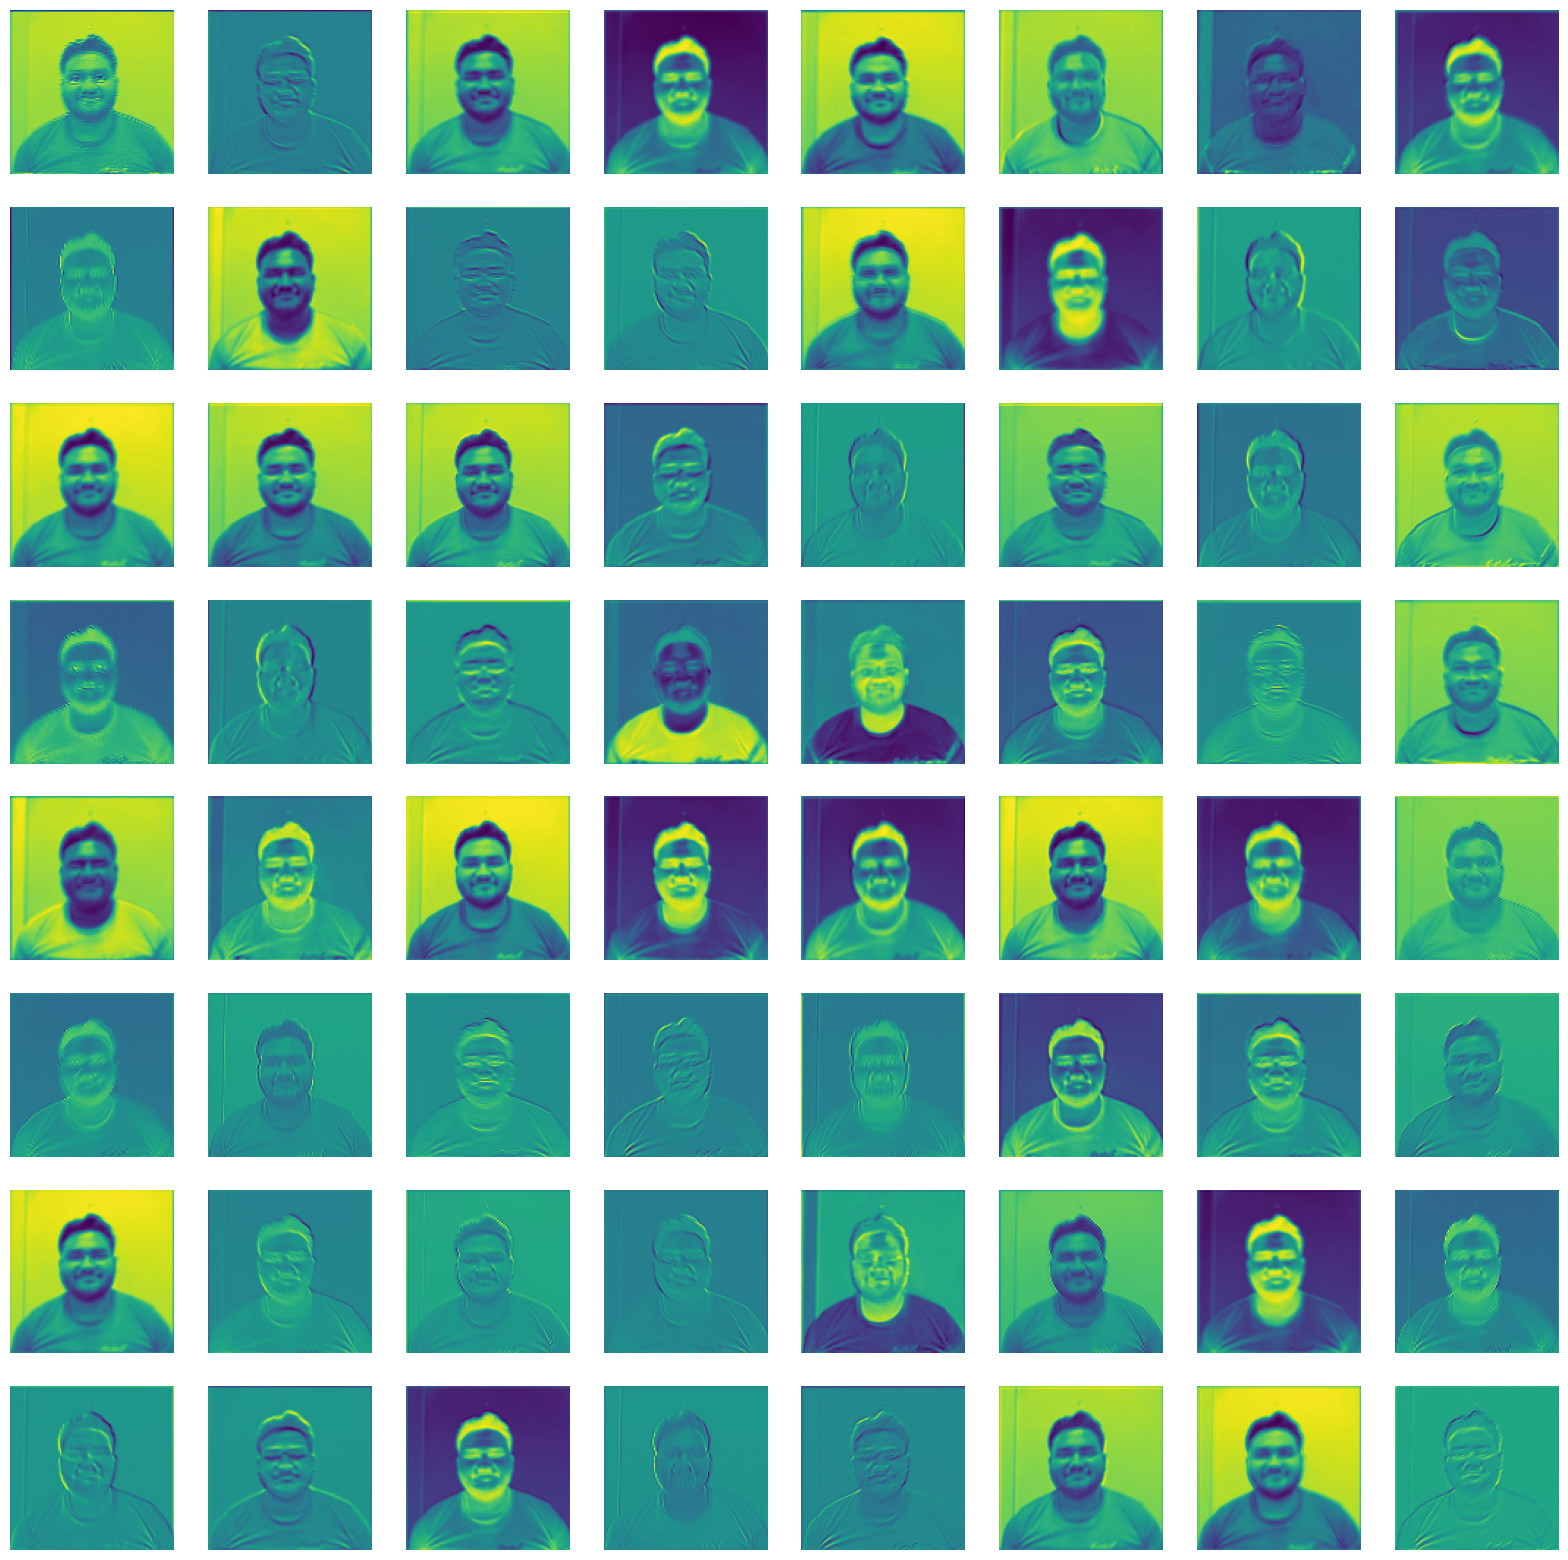

In [26]:
# Hook function to capture activations for conv1
activation_conv1 = None
def hook_conv1(module, input, output):
    global activation_conv1
    activation_conv1 = output

layer_conv1 = dict([*model.named_modules()])['conv1']
hook = layer_conv1.register_forward_hook(hook_conv1)

image_path = 'Kanishk.jpeg'  # Replace with your image path
input_image = preprocess_image(image_path)

# Forward pass
with torch.no_grad():
    _ = model(input_image)

# Visualize activations for conv1
print("Visualizing activations from conv1...")
visualize_activations(activation_conv1)

# Remove hook for conv1 after visualization
hook.remove()

Visualizing activations from layer1...


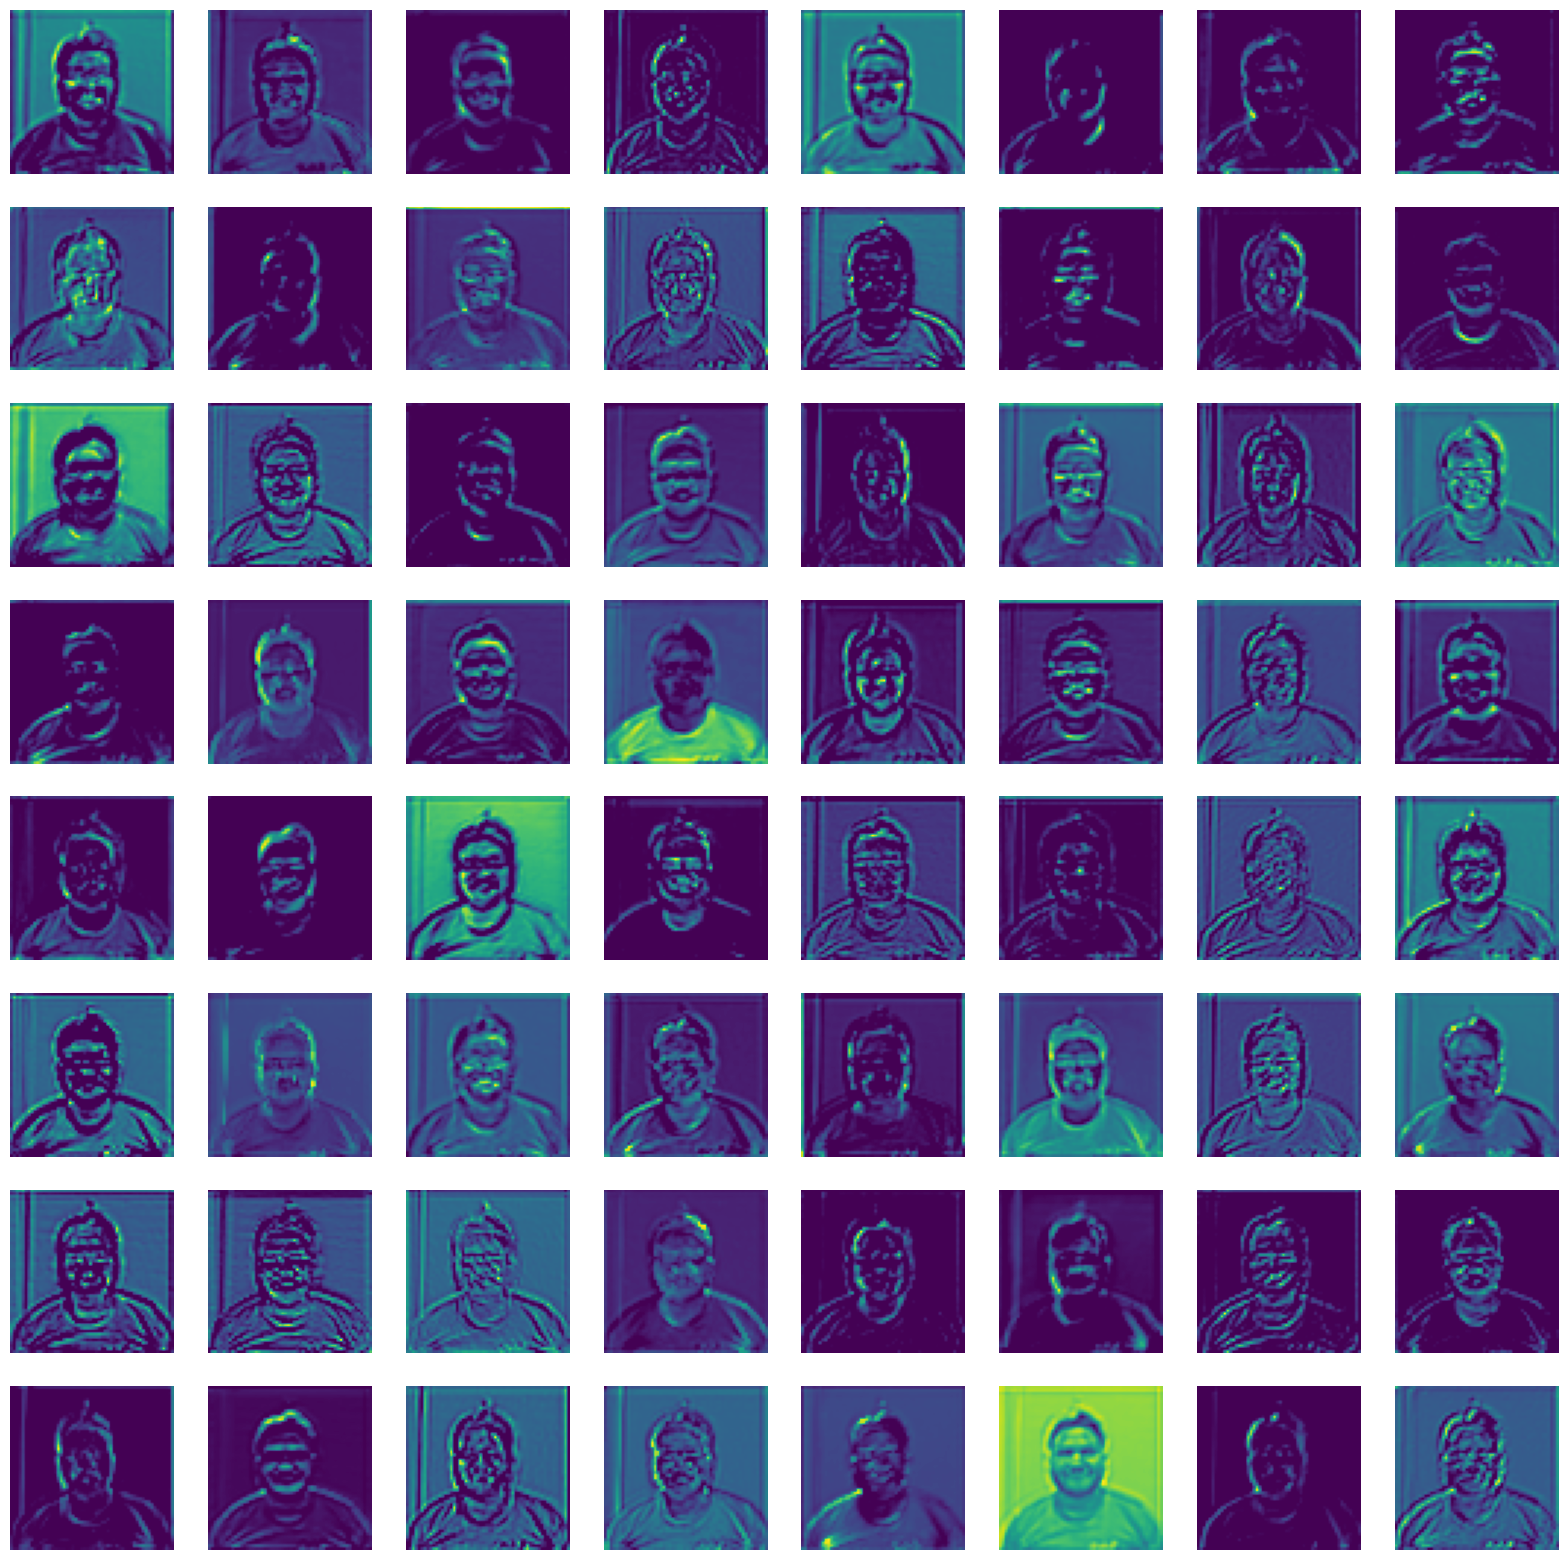

In [28]:
# Hook function
activation_layer1 = None
def hook_layer1(module, input, output):
    global activation_layer1
    activation_layer1 = output

layer_layer1 = dict([*model.named_modules()])['layer1']
hook = layer_layer1.register_forward_hook(hook_layer1)

input_image = preprocess_image(image_path)

# Forward pass
with torch.no_grad():
    _ = model(input_image)

# Visualize activations for layer1
print("Visualizing activations from layer1...")
visualize_activations(activation_layer1)

# Remove hook
hook.remove()

Visualizing activations from layer2...


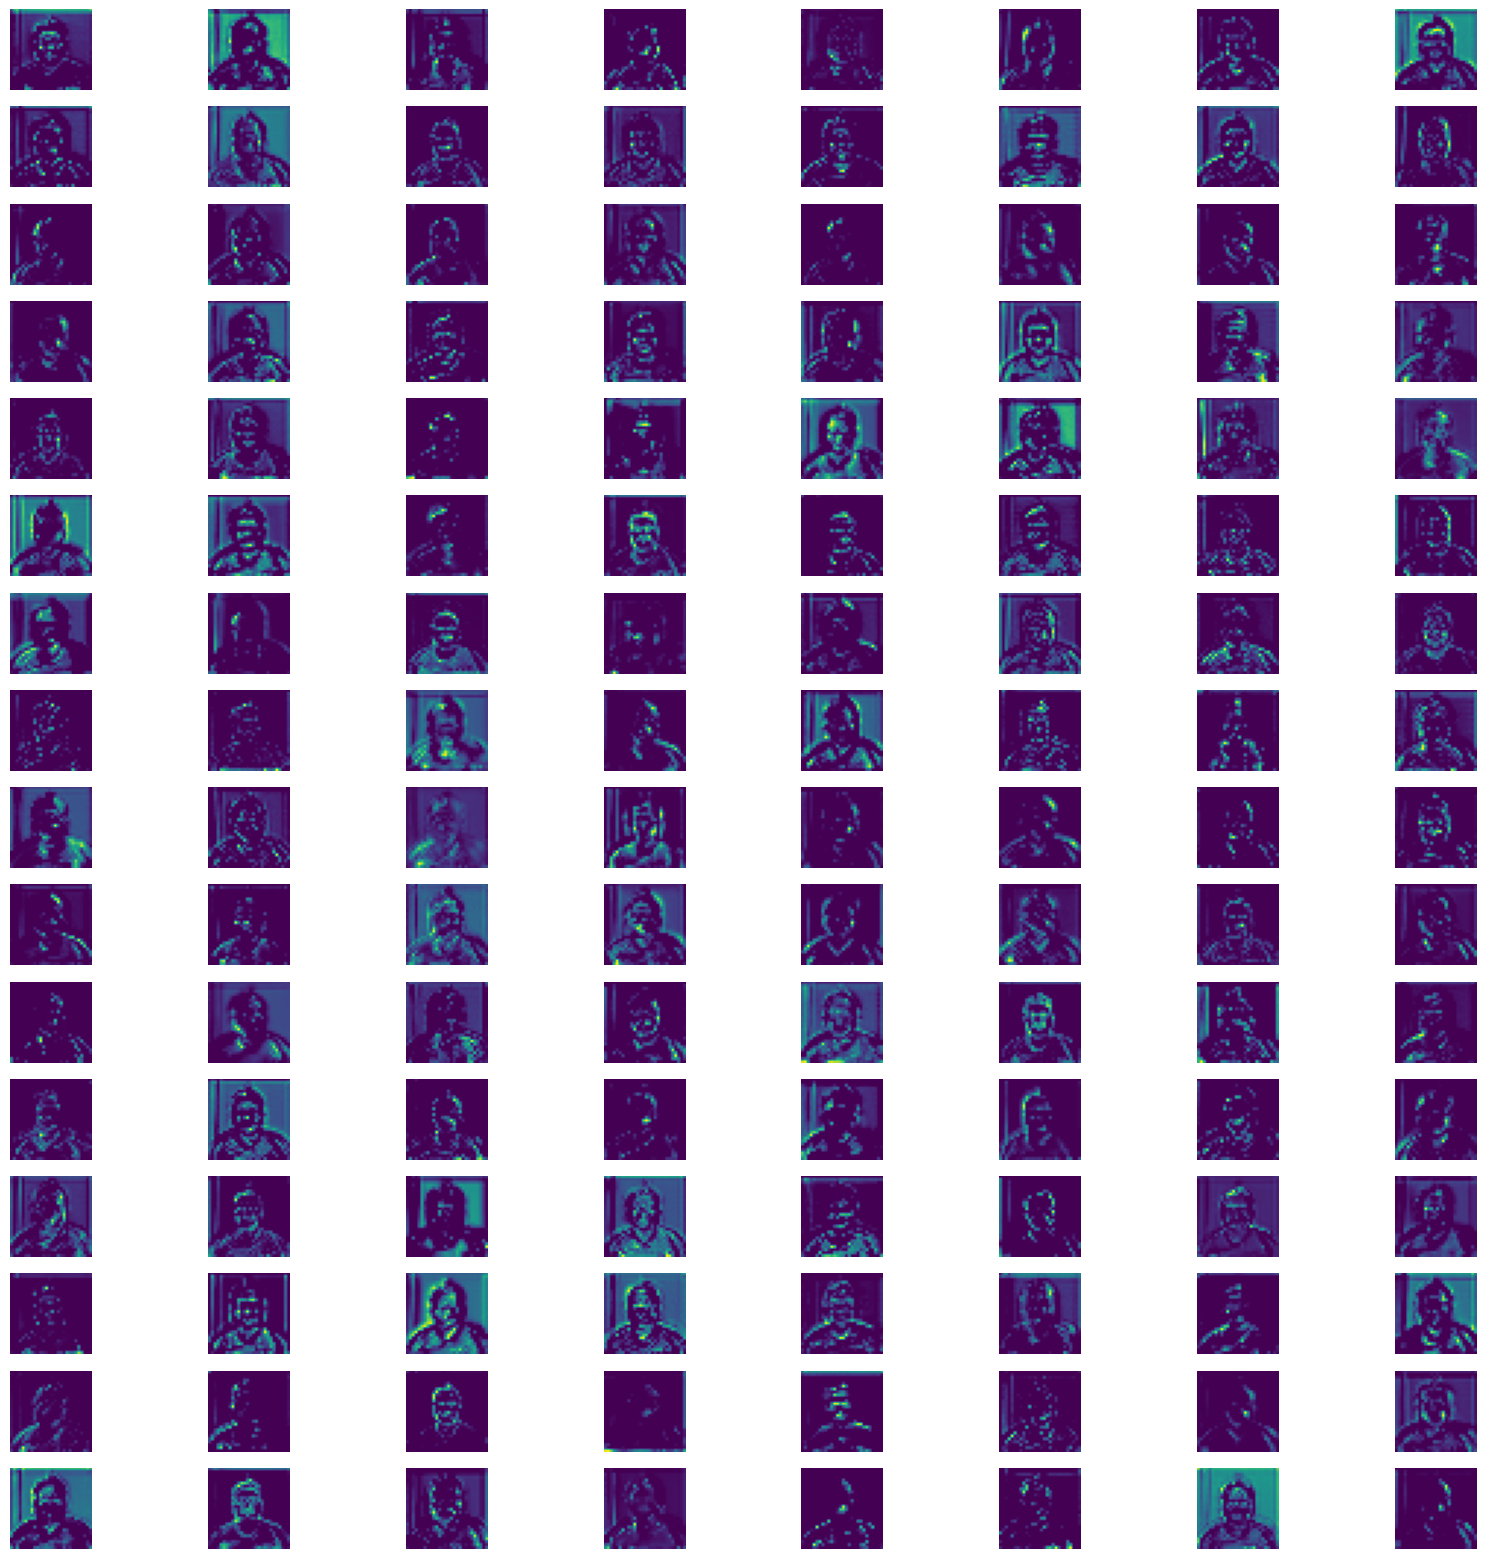

In [29]:
# Hook function
activation_layer2 = None
def hook_layer2(module, input, output):
    global activation_layer2
    activation_layer2 = output

# Register hook for layer2
layer_layer2 = dict([*model.named_modules()])['layer2']
hook = layer_layer2.register_forward_hook(hook_layer2)

input_image = preprocess_image(image_path)

# Forward pass
with torch.no_grad():
    _ = model(input_image)

# Visualize activations for layer2
print("Visualizing activations from layer2...")
visualize_activations(activation_layer2)

hook.remove()

Visualizing activations from layer3...


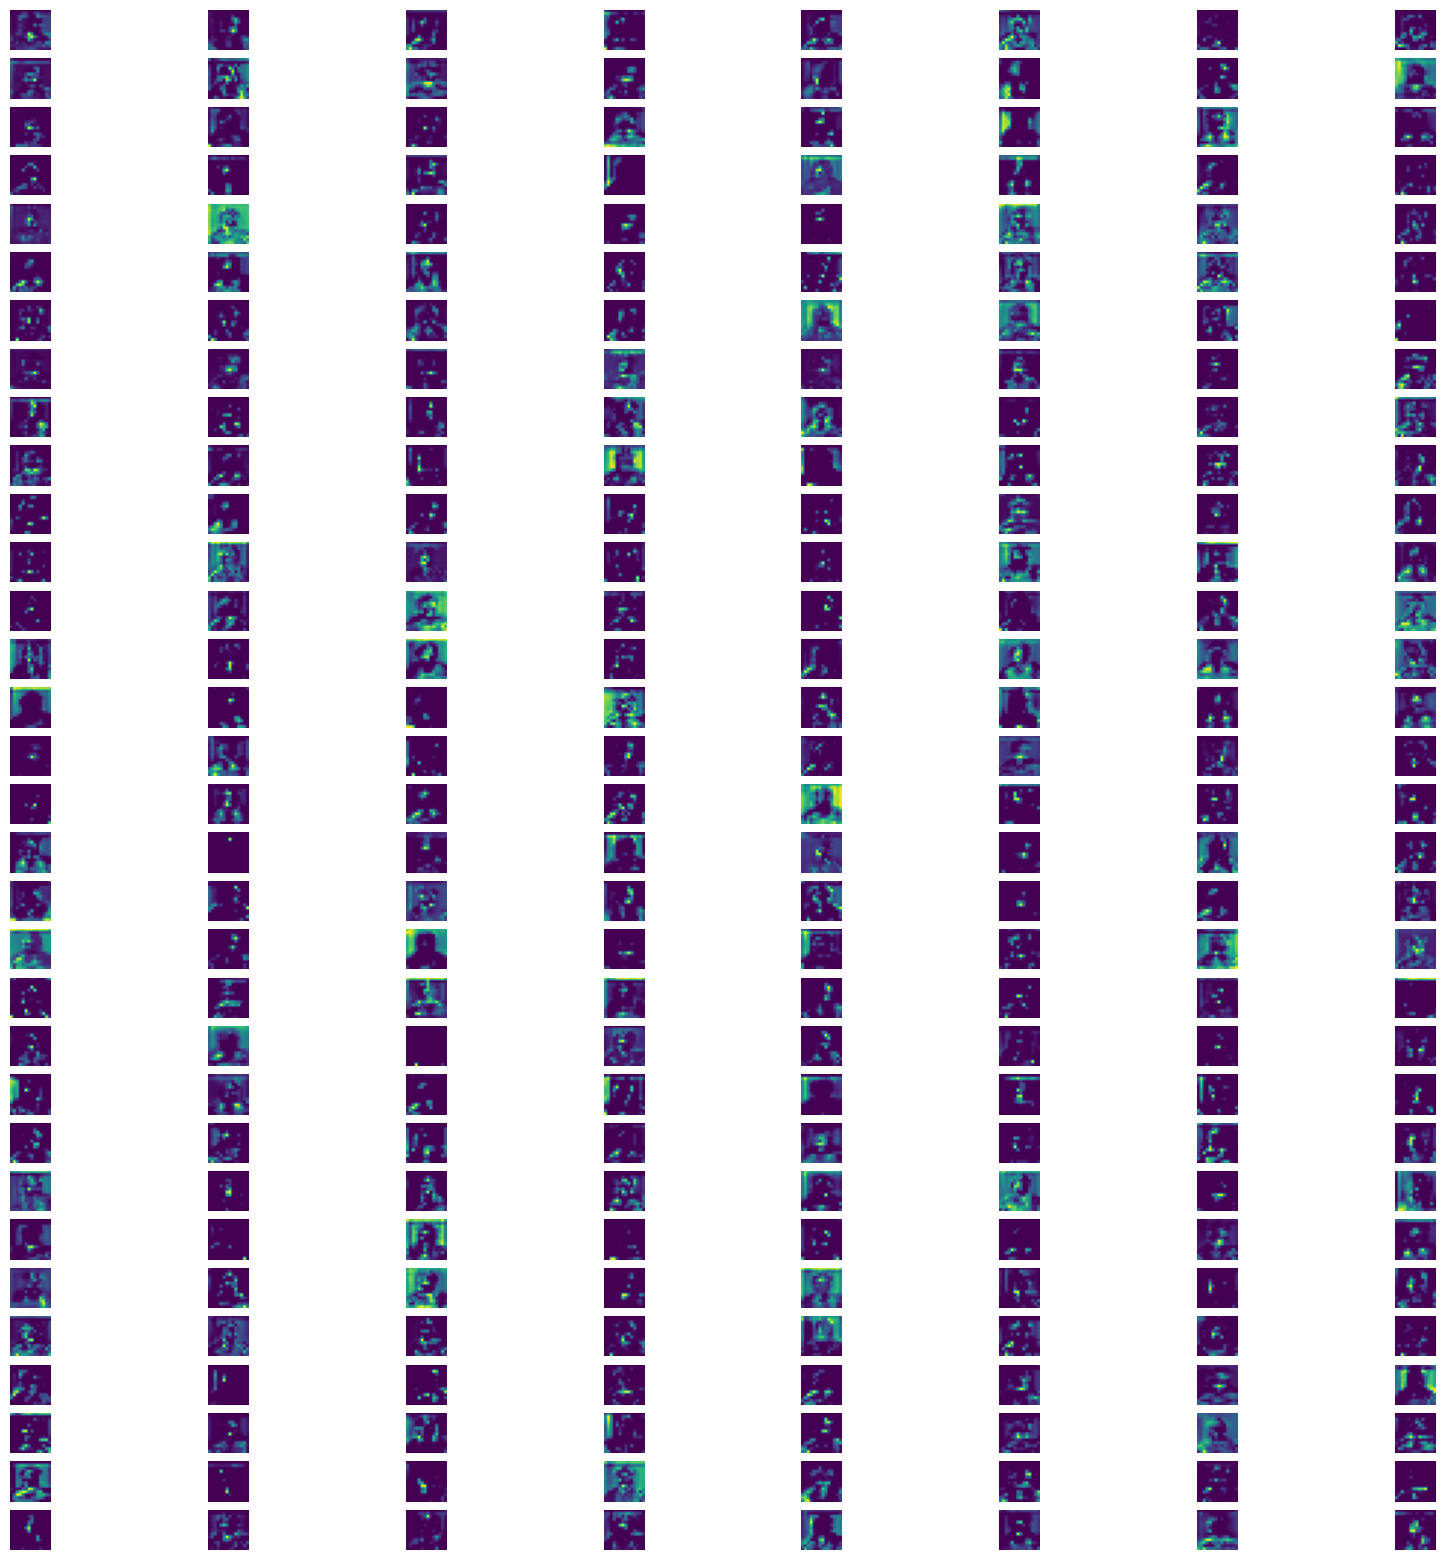

In [30]:
# Hook function
activation_layer3 = None
def hook_layer3(module, input, output):
    global activation_layer3
    activation_layer3 = output

layer_layer3 = dict([*model.named_modules()])['layer3']
hook = layer_layer3.register_forward_hook(hook_layer3)

input_image = preprocess_image(image_path)

# Forward pass
with torch.no_grad():
    _ = model(input_image)

# Visualize activations for layer3
print("Visualizing activations from layer3...")
visualize_activations(activation_layer3)

hook.remove()

Visualizing activations from layer4...


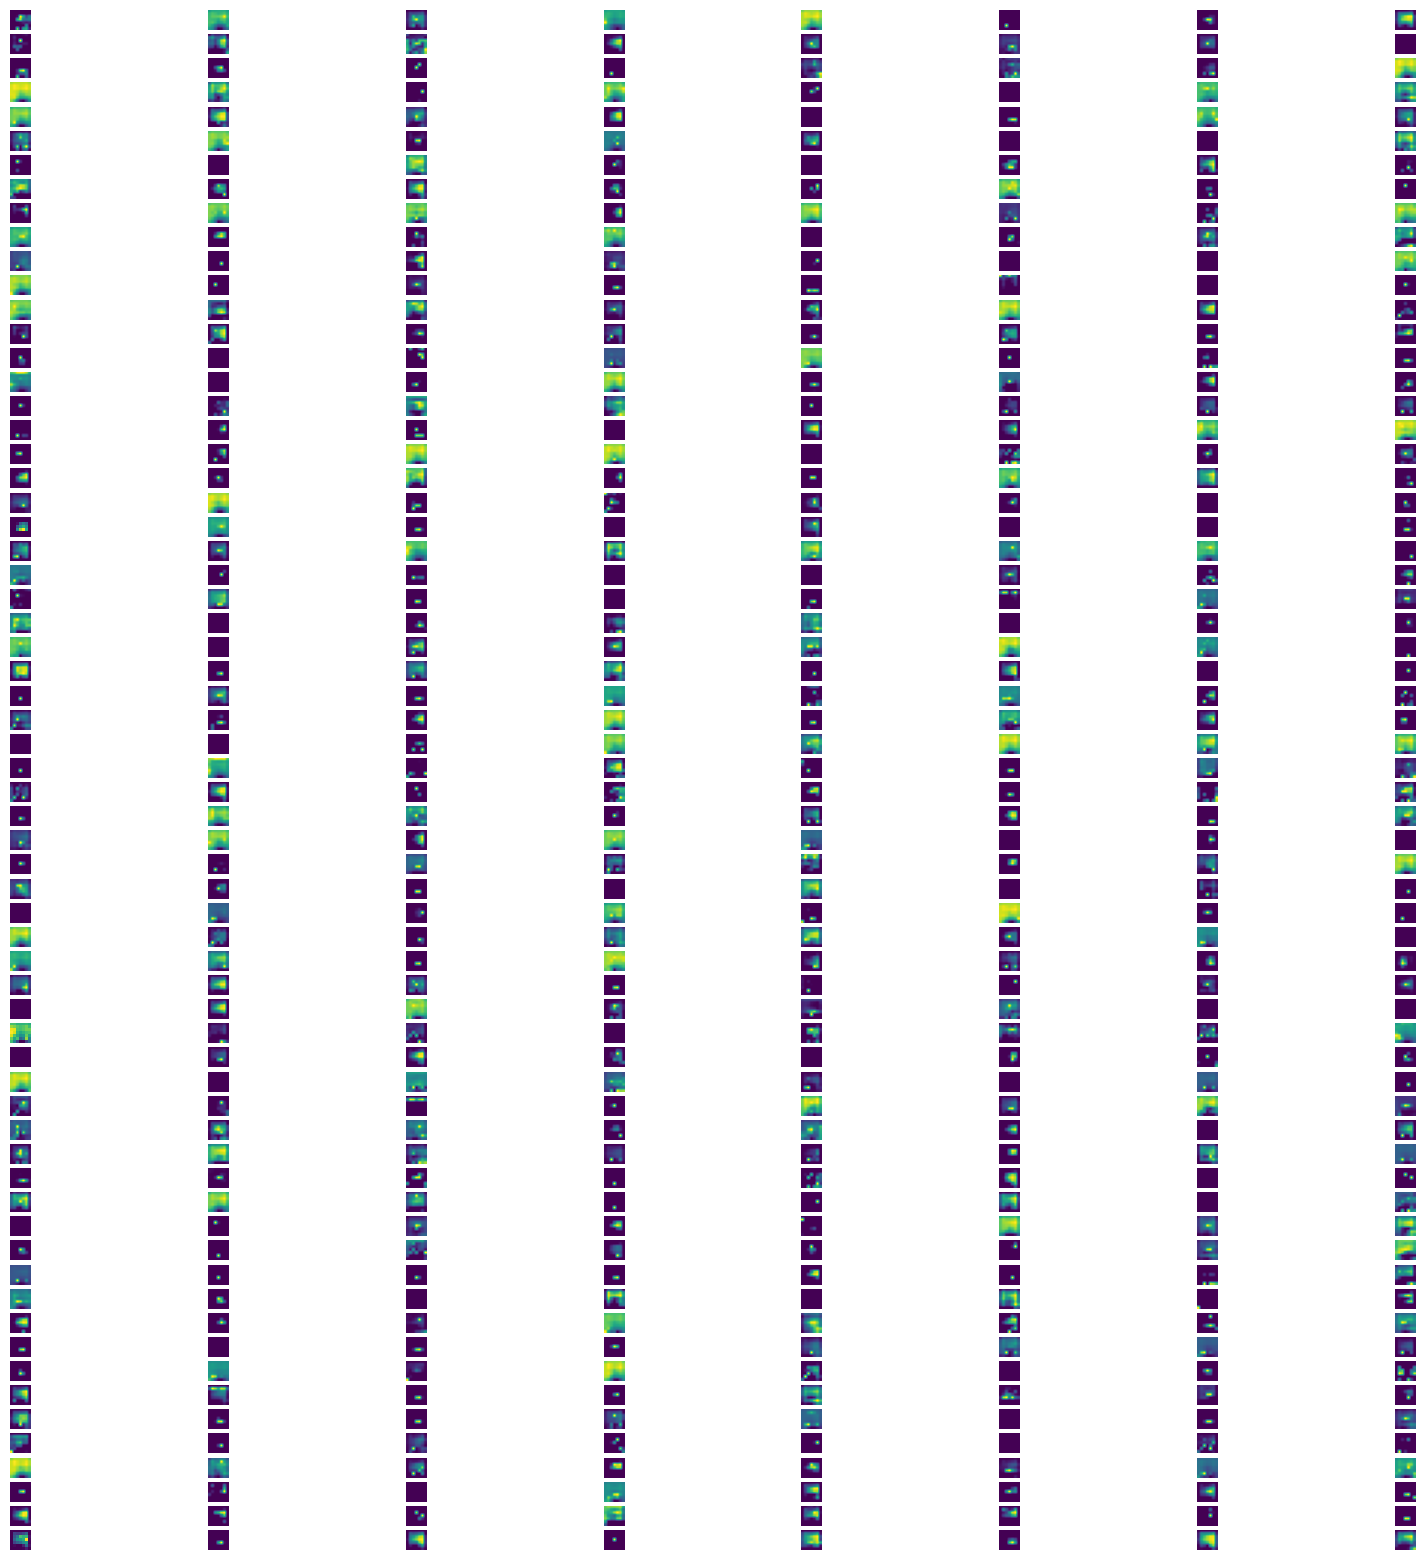

In [31]:
# Hook function
activation_layer4 = None
def hook_layer4(module, input, output):
    global activation_layer4
    activation_layer4 = output

layer_layer4 = dict([*model.named_modules()])['layer4']
hook = layer_layer4.register_forward_hook(hook_layer4)

input_image = preprocess_image(image_path)

# Forward pass
with torch.no_grad():
    _ = model(input_image)

# Visualize activations for layer4
print("Visualizing activations from layer4...")
visualize_activations(activation_layer4)

hook.remove()

In [32]:
# Function to visualize the filters (weights)
def visualize_filters(layer_weights, num_columns=8):
    num_filters = layer_weights.shape[0]
    
    num_rows = (num_filters + num_columns - 1) // num_columns
    
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 20))
    axes = axes.flatten()

    # Normalize the filters for better visualization
    layer_weights = (layer_weights - layer_weights.min()) / (layer_weights.max() - layer_weights.min())

    for i in range(num_filters):
        if layer_weights.shape[1] == 3:  # RGB filters
            img = layer_weights[i].permute(1, 2, 0).cpu().detach().numpy()
        else:  # Grayscale filters
            img = layer_weights[i, 0].cpu().detach().numpy()
        axes[i].imshow(img)
        axes[i].axis('off')

    for i in range(num_filters, len(axes)):
        axes[i].axis('off')
    
    plt.show()

Visualizing filters from conv1...


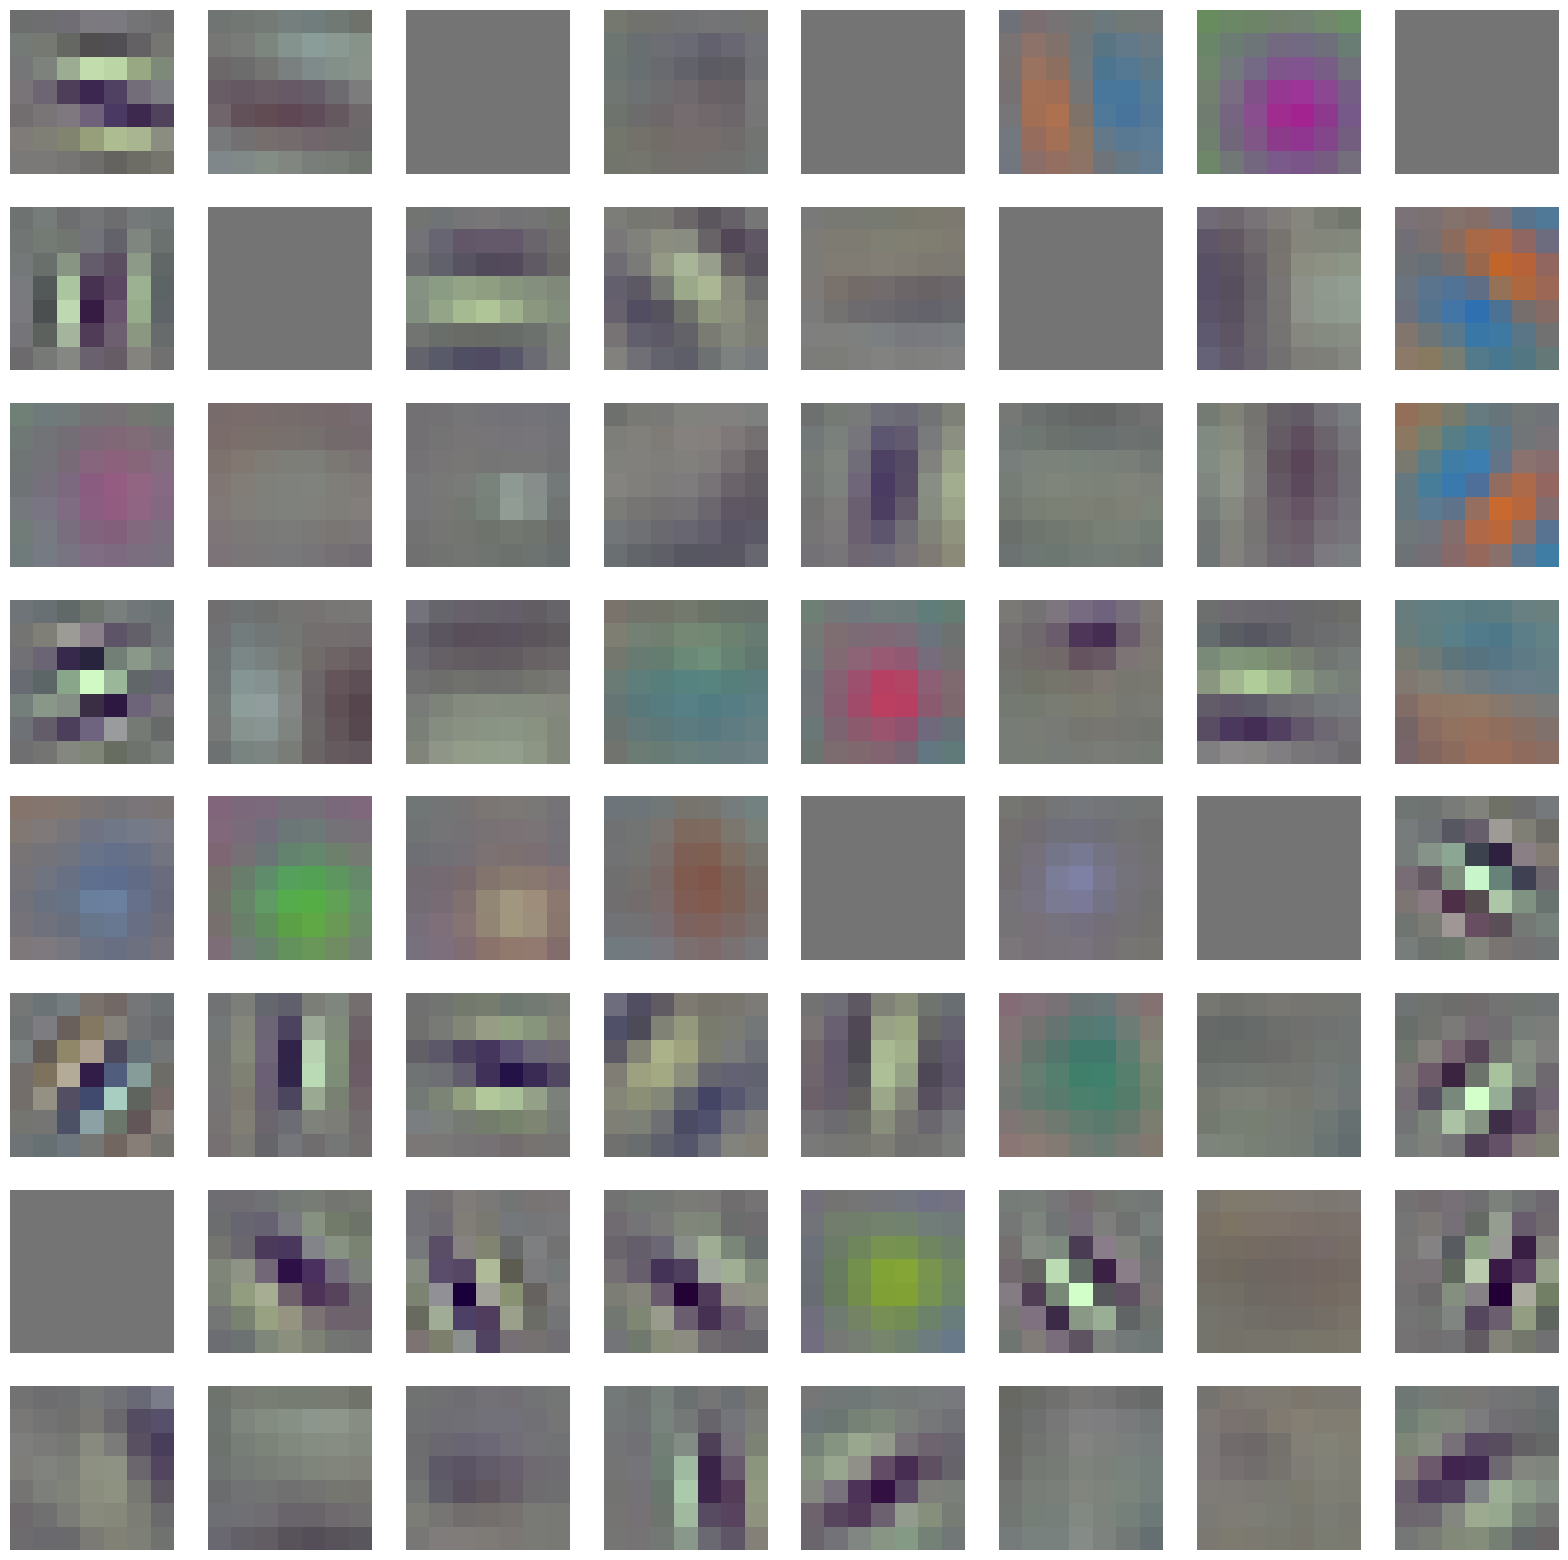

Visualizing filters from layer1.0.conv1...


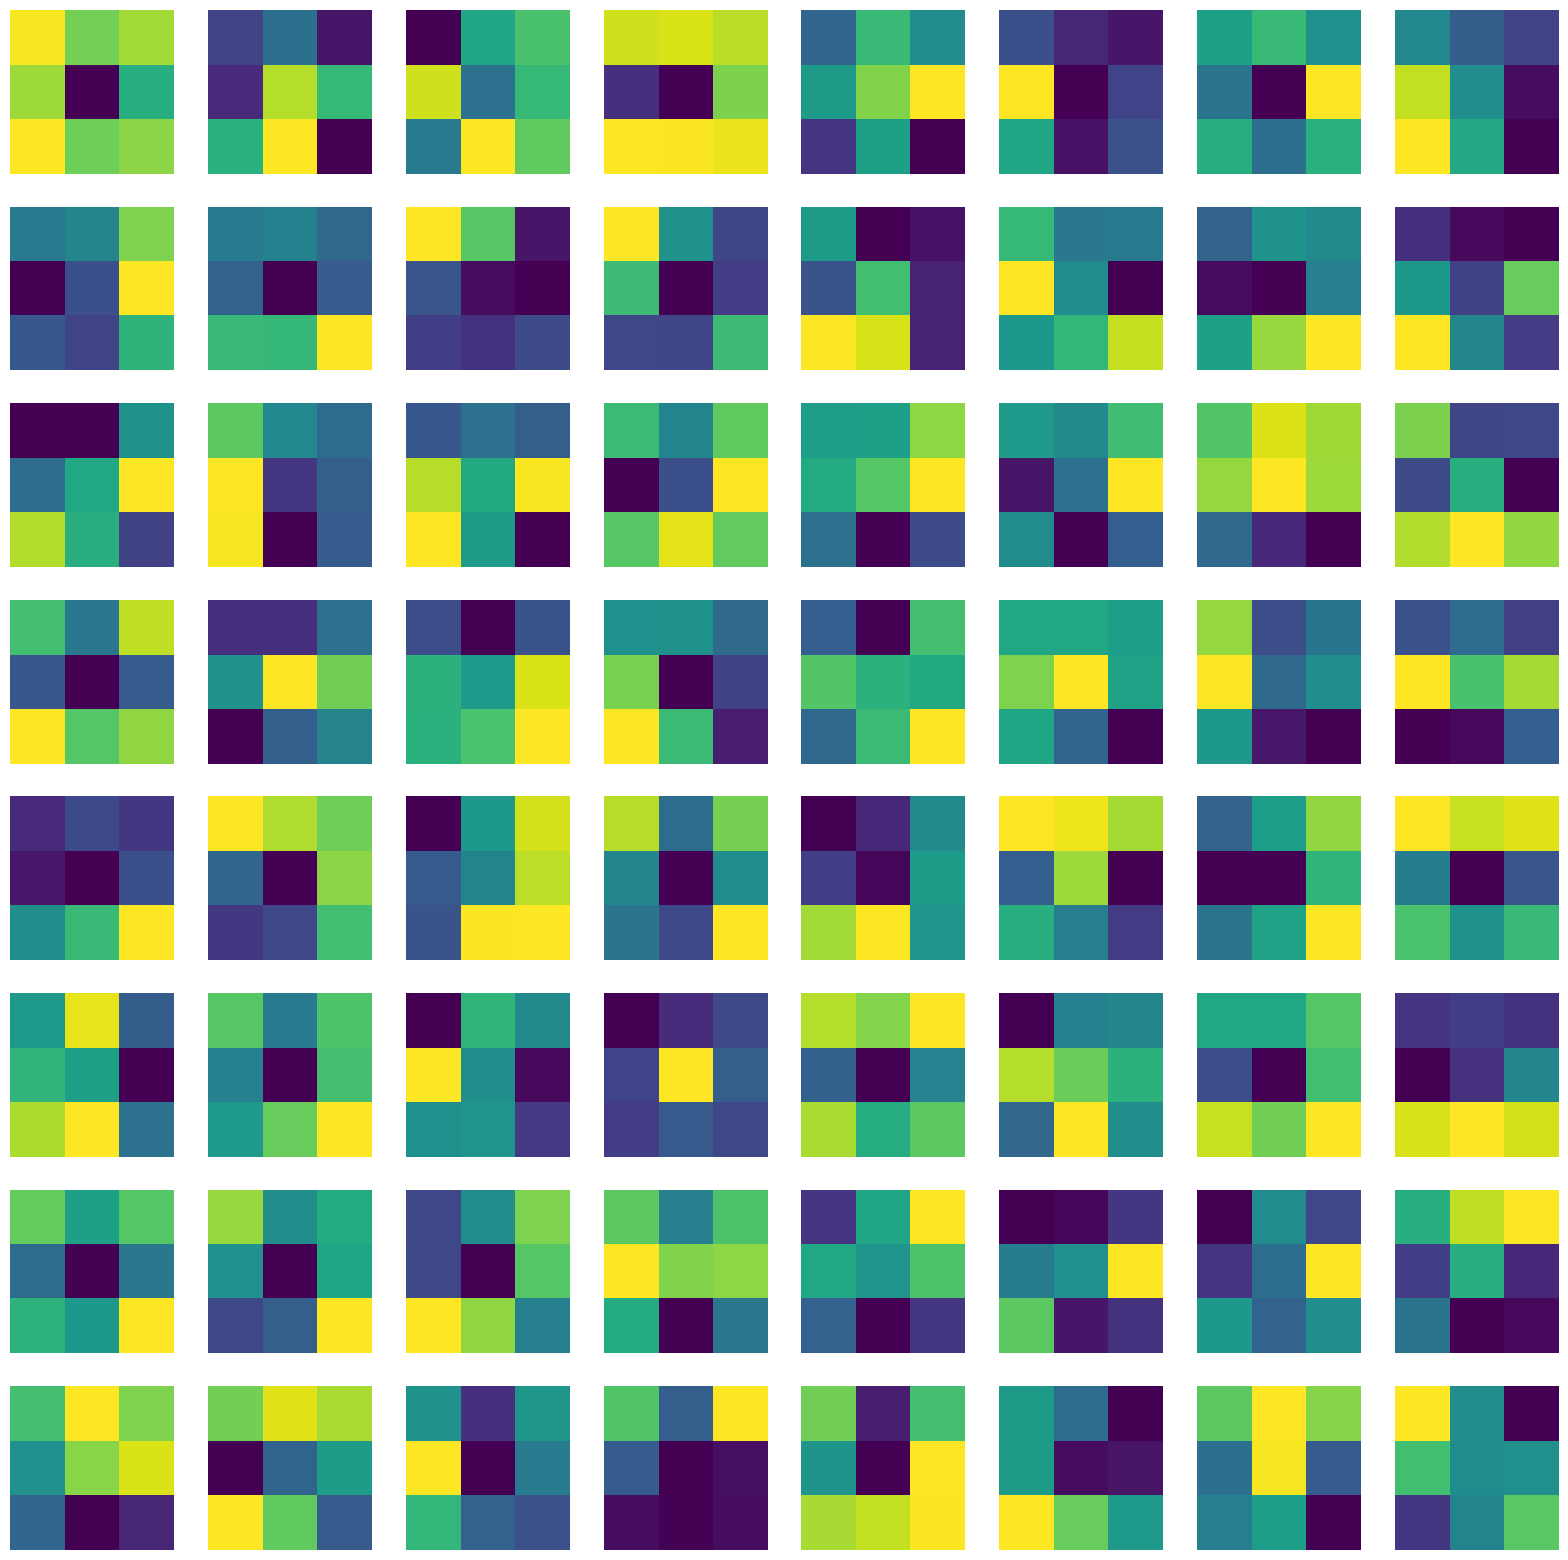

Visualizing filters from layer2.0.conv1...


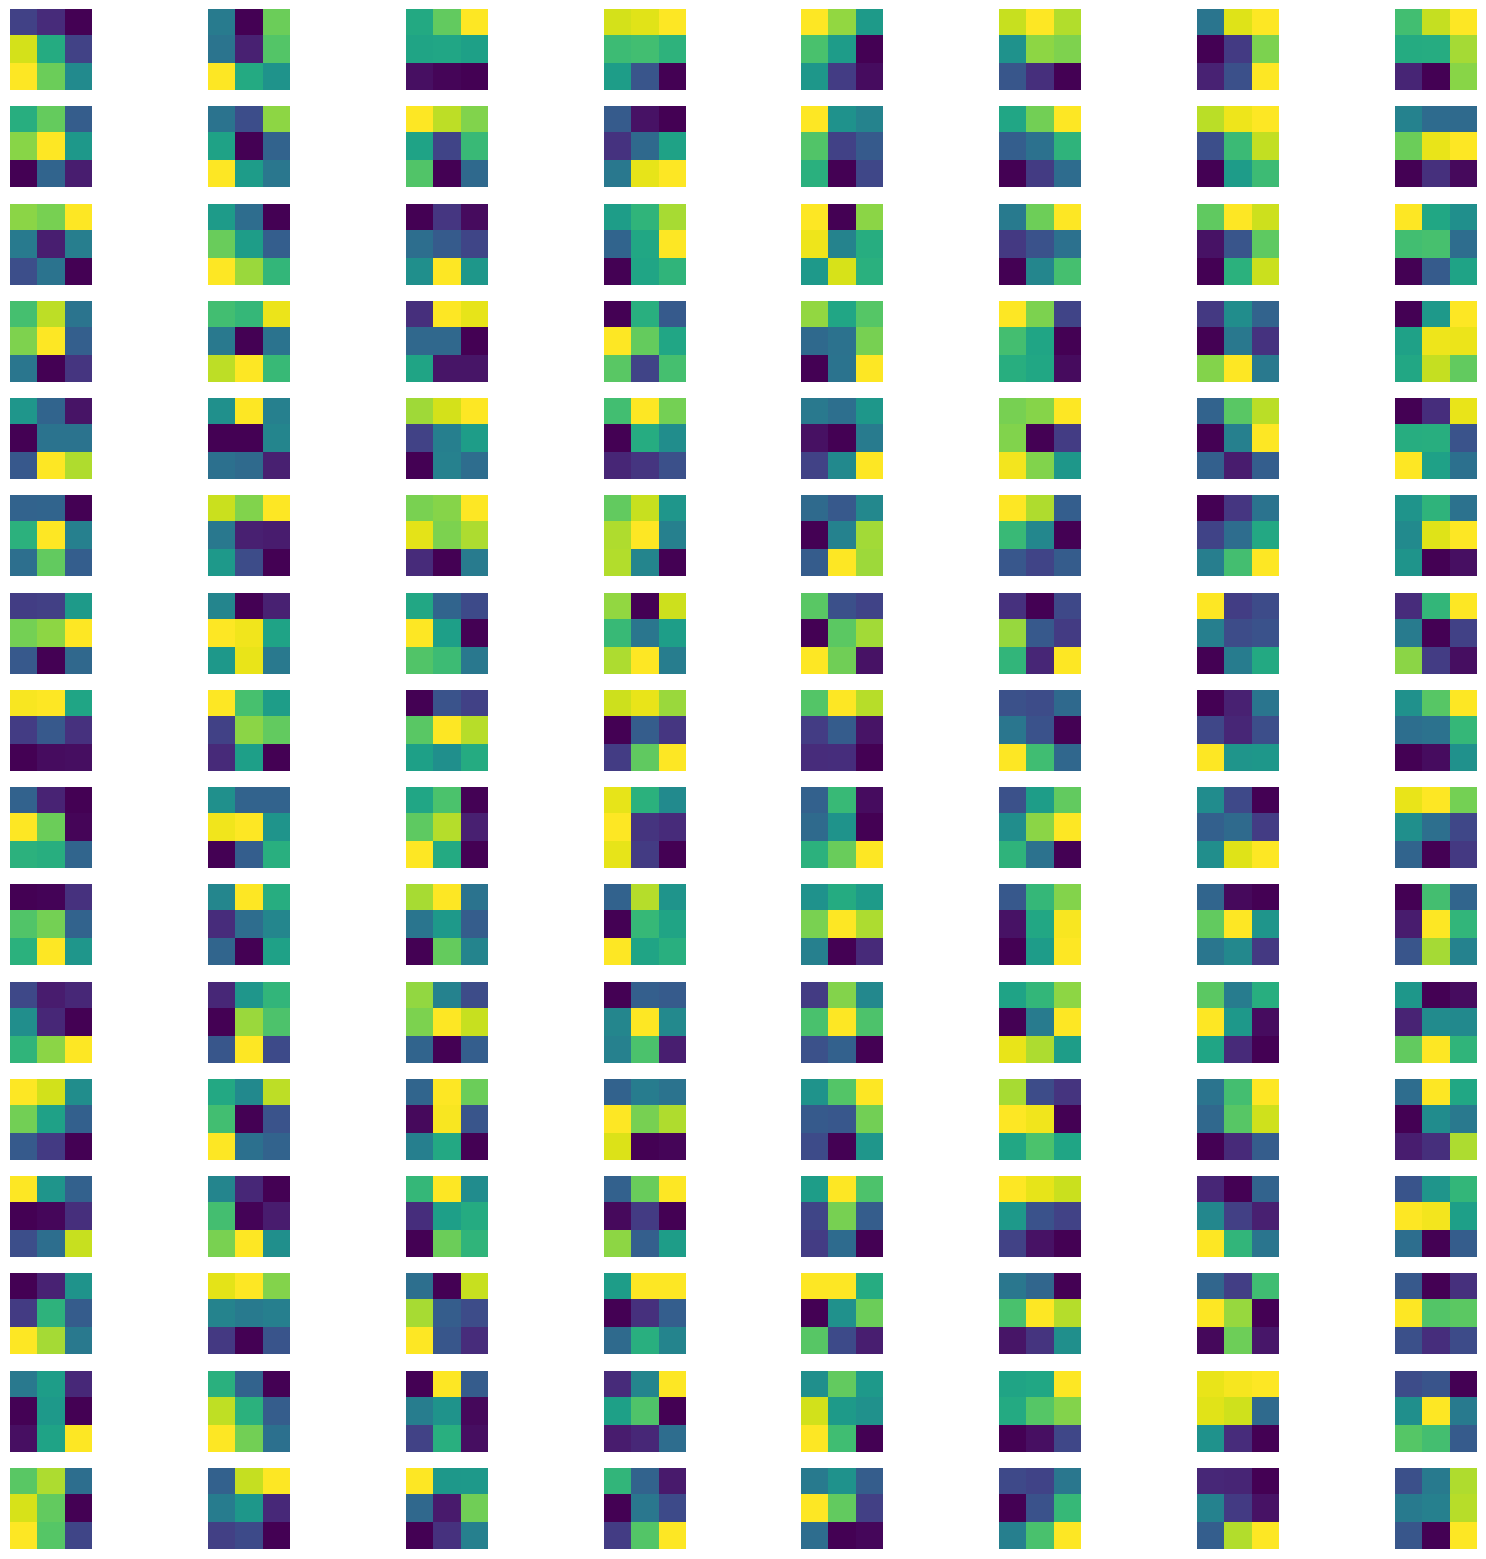

Visualizing filters from layer3.0.conv1...


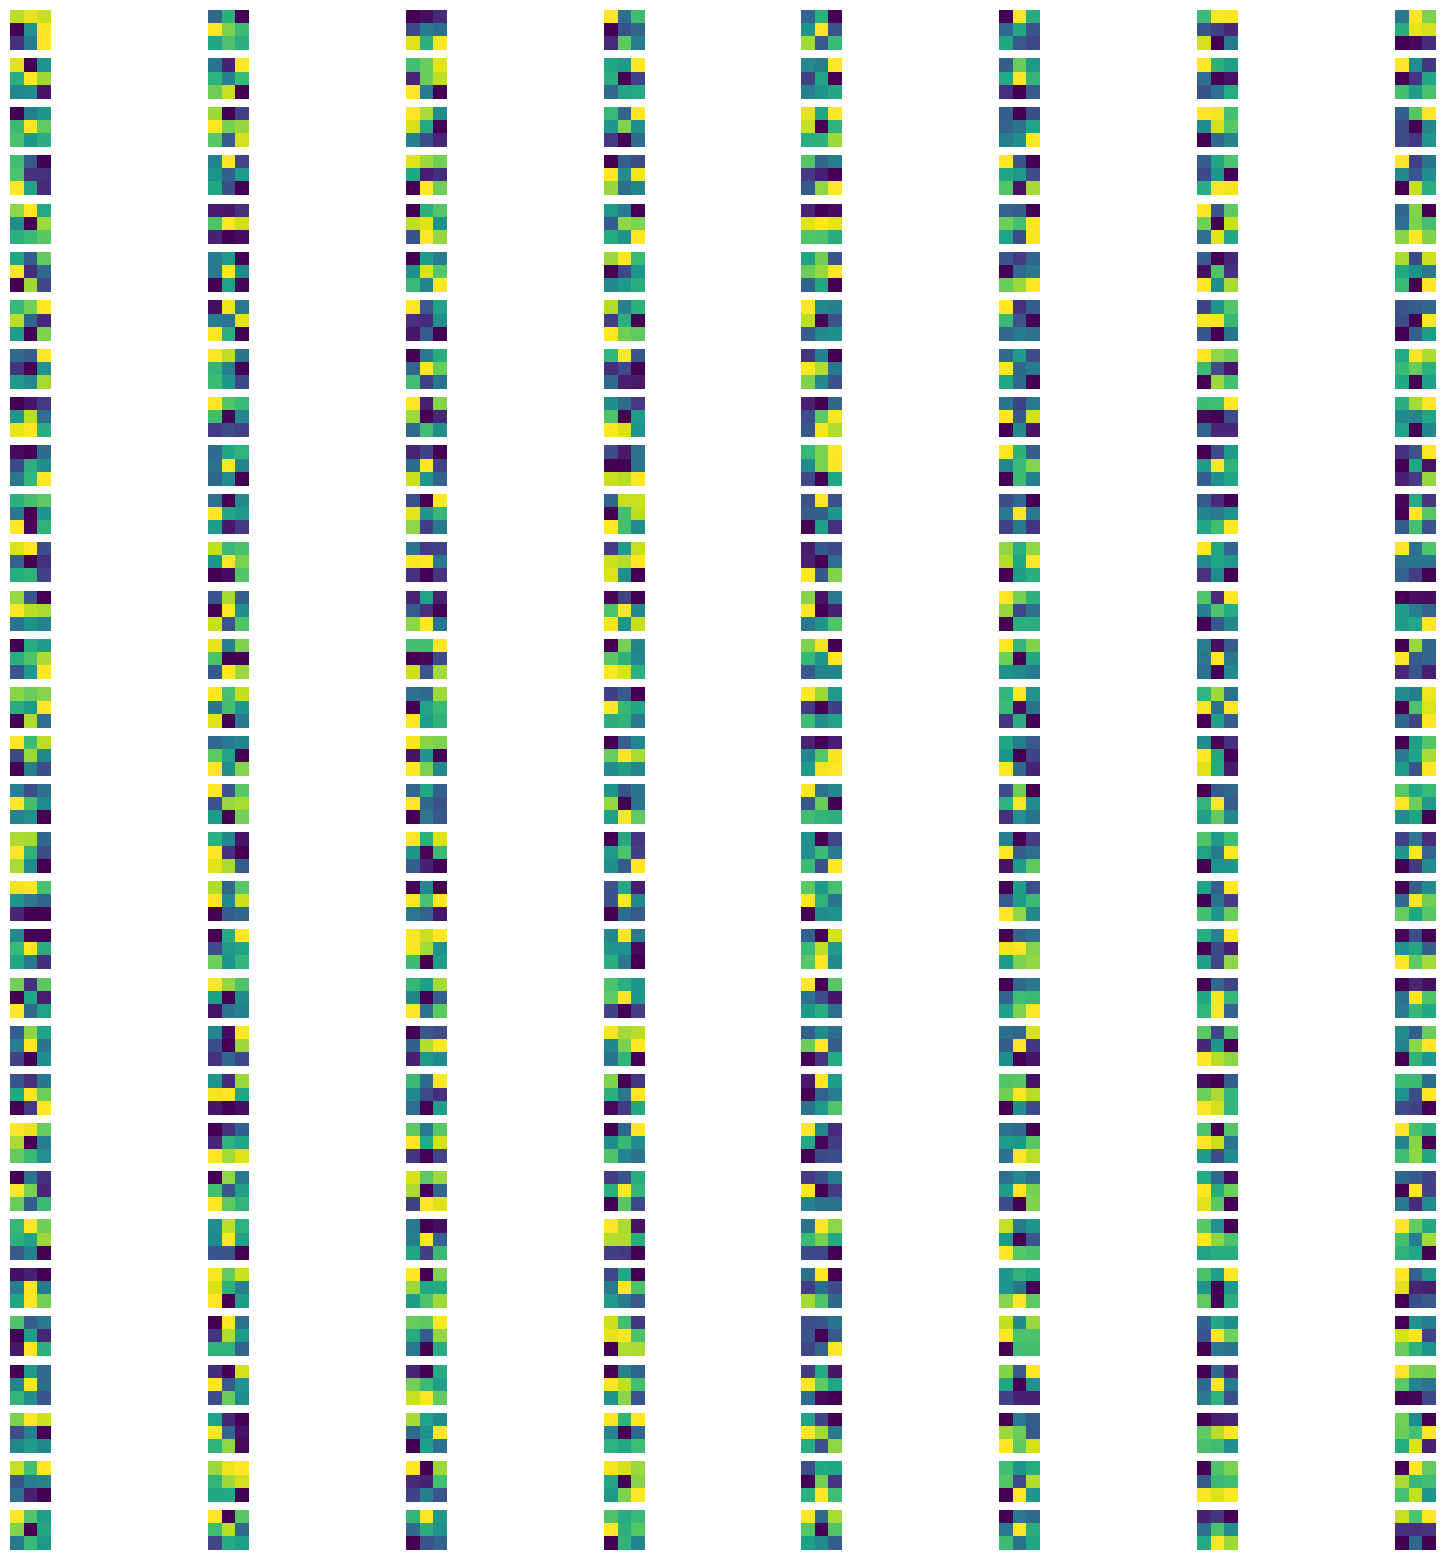

Visualizing filters from layer4.0.conv1...


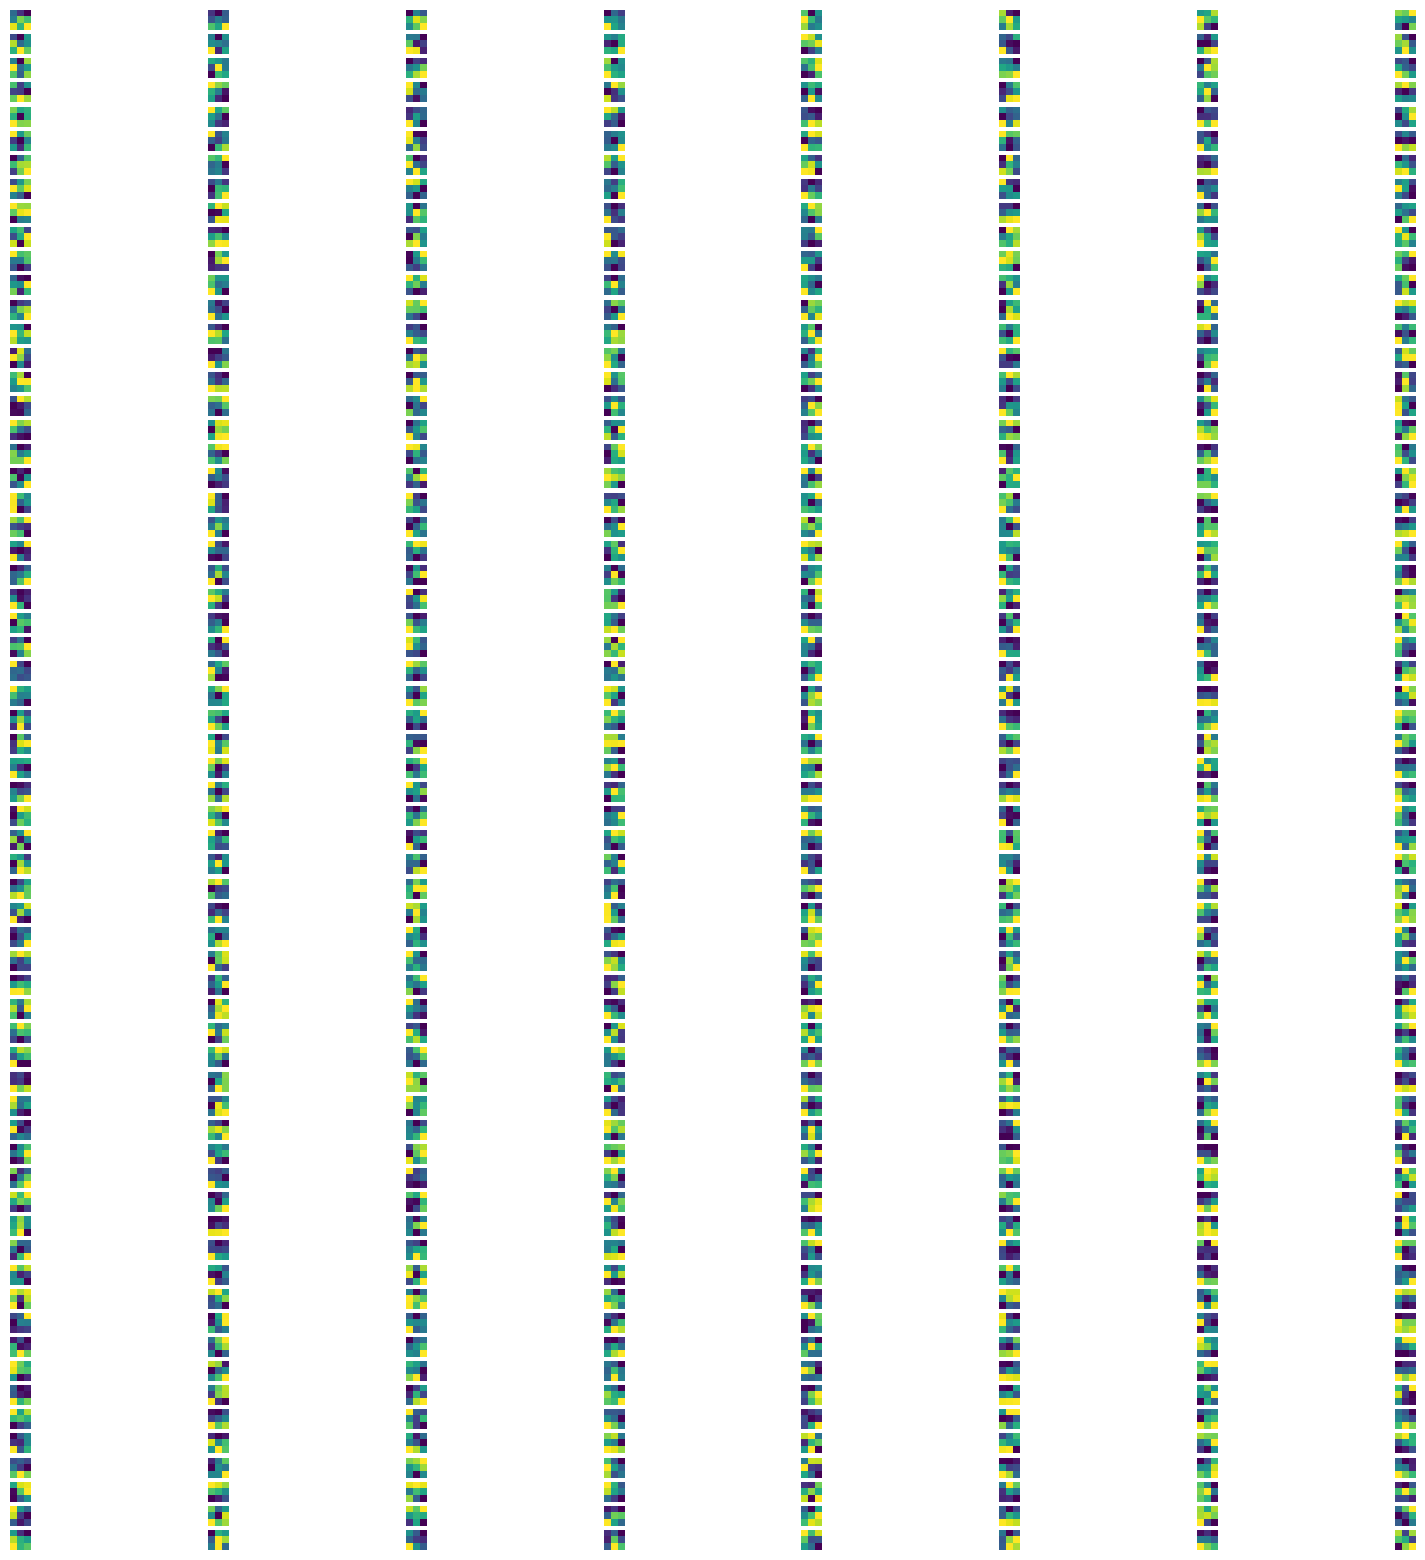

In [33]:
# Visualize the filters from the convolutional layers
# ADD MORE FILTERS in the list below, if you want them to be visualised
for layer_name in ['conv1', 'layer1.0.conv1', 'layer2.0.conv1', 'layer3.0.conv1', 'layer4.0.conv1']:
    print(f"Visualizing filters from {layer_name}...")
    layer = dict([*model.named_modules()])[layer_name]
    filters = layer.weight.data
    visualize_filters(filters)

## Occlusion Map

In [34]:
# Load the model and weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=1)
model.load_state_dict(torch.load('resnet18_arched_eyebrows.pth'))
model = model.to(device)
model.eval()

image_path = 'Kanishk.jpeg'  # Replace with your image path
input_image = preprocess_image(image_path)
input_image = input_image.to(device)

# Running inference on the image without occlusion
with torch.no_grad():
    outputs = model(input_image)
    outputs = torch.sigmoid(outputs)  # Sigmoid

# Assuming binary classification, we round the output to get the predicted label (0 or 1)
pred = torch.round(outputs).item()
print(f"Predicted label without occlusion: {pred}")

if pred == 1.0:
    print("Prediction: Arched Eyebrows")
else:
    print("Prediction: Not Arched Eyebrows")
print(f"Probability of the predicted class without occlusion: {outputs.item()}")

Predicted label without occlusion: 0.0
Prediction: Not Arched Eyebrows
Probability of the predicted class without occlusion: 0.1153743639588356


/tmp/ipykernel_5264/1622575736.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet18_arched_eyebrows.pth'))


In [35]:
# Occlusion experiment function
def occlusion(model, image, label, occ_size=50, occ_stride=50, occ_pixel=0.5):
    width, height = image.shape[-2], image.shape[-1]
    output_height = (height - occ_size) // occ_stride + 1
    output_width = (width - occ_size) // occ_stride + 1

    heatmap = torch.zeros((output_height, output_width))

    for h in range(0, height-occ_size+1, occ_stride):
        for w in range(0, width-occ_size+1, occ_stride):
            # Create a copy of the image and apply occlusion
            input_image = image.clone().detach()
            input_image[:, :, h:h+occ_size, w:w+occ_size] = occ_pixel

            # Run inference on the occluded image
            with torch.no_grad():
                output_occ = model(input_image)
                prob_occ = torch.sigmoid(output_occ).item()

            heatmap[h // occ_stride, w // occ_stride] = prob_occ

    return heatmap

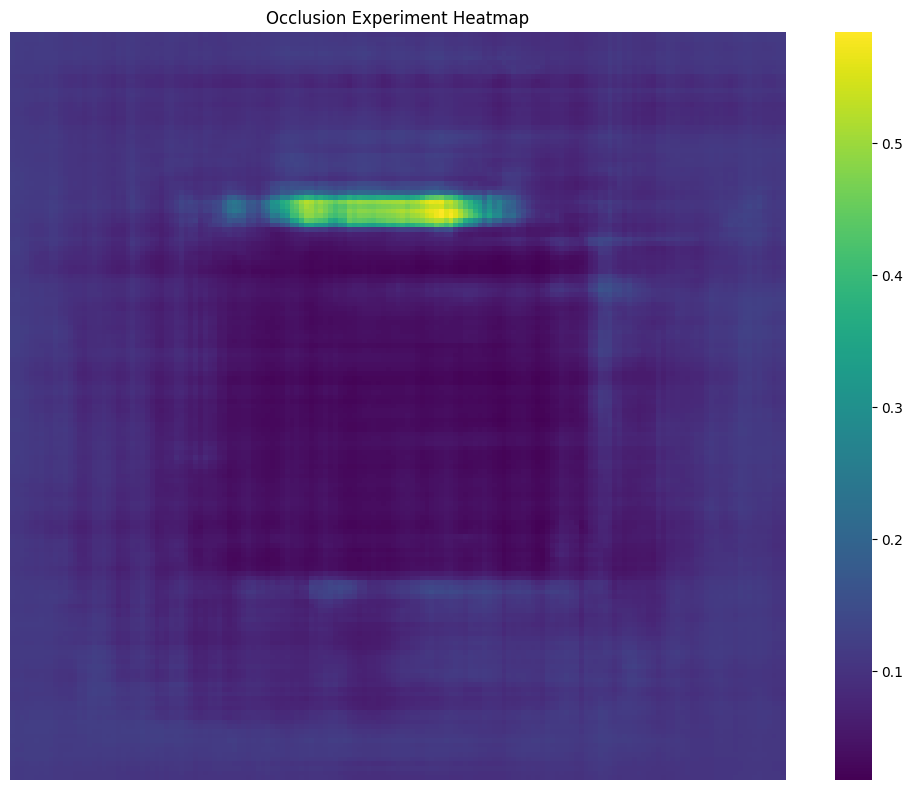

In [38]:
# Conducting occlusion experiment
label_idx = int(pred)
heatmap = occlusion(model, input_image, label_idx, occ_size=64, occ_stride=1)
# Plotting the occlusion heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap, xticklabels=False, yticklabels=False, cmap='viridis')
plt.title("Occlusion Experiment Heatmap")
plt.tight_layout()
plt.show()

In [37]:
# Print out all named modules in the model to verify layer names
for name, module in model.named_modules():
    print(name)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.relu
layer1.0.conv2
layer1.0.bn2
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.relu
layer1.1.conv2
layer1.1.bn2
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.relu
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.relu
layer2.1.conv2
layer2.1.bn2
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.relu
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample
layer3.0.downsample.0
layer3.0.downsample.1
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.relu
layer3.1.conv2
layer3.1.bn2
layer4
layer4.0
layer4.0.conv1
layer4.0.bn1
layer4.0.relu
layer4.0.conv2
layer4.0.bn2
layer4.0.downsample
layer4.0.downsample.0
layer4.0.downsample.1
layer4.1
layer4.1.conv1
layer4.1.bn1
layer4.1.relu
layer4.1.conv2
layer4.1.bn2
avgpool
fc
